<a href="https://colab.research.google.com/github/aureeliano/Sugeno/blob/main/Sugeno_Errobidart_Vega_Imbalde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## **Subtractive Clustering**

In [ ]:
"""Subtractive Clustering Algorithm
"""
__author__ = 'Daniel Albornoz'


import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance_matrix

def subclust2(data, Ra, Rb=0, AcceptRatio=0.3, RejectRatio=0.1):
    if Rb==0:
        Rb = Ra*1.15

    scaler = MinMaxScaler()
    scaler.fit(data)
    ndata = scaler.transform(data)

    # 14/05/2020 cambio list comprehensions por distance matrix
    #P = np.array([np.sum([np.exp(-(np.linalg.norm(u-v)**2)/(Ra/2)**2) for v in ndata]) for u in ndata])
    #print(P)
    P = distance_matrix(ndata,ndata)
    alpha=(Ra/2)**2
    P = np.sum(np.exp(-P**2/alpha),axis=0)

    centers = []
    i=np.argmax(P)
    C = ndata[i]
    p=P[i]
    centers = [C]

    continuar=True
    restarP = True
    while continuar:
        pAnt = p
        if restarP:
            P=P-p*np.array([np.exp(-np.linalg.norm(v-C)**2/(Rb/2)**2) for v in ndata])
        restarP = True
        i=np.argmax(P)
        C = ndata[i]
        p=P[i]
        if p>AcceptRatio*pAnt:
            centers = np.vstack((centers,C))
        elif p<RejectRatio*pAnt:
            continuar=False
        else:
            dr = np.min([np.linalg.norm(v-C) for v in centers])
            if dr/Ra+p/pAnt>=1:
                centers = np.vstack((centers,C))
            else:
                P[i]=0
                restarP = False
        if not any(v>0 for v in P):
            continuar = False
    distancias = [[np.linalg.norm(p-c) for p in ndata] for c in centers]
    labels = np.argmin(distancias, axis=0)
    centers = scaler.inverse_transform(centers)

    return labels, centers

## **Sugeno Implementation**

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Wed May  6 17:56:16 2020

@author: Daniel Albornoz

Implementación similar a genfis2 de Matlab.
Sugeno type FIS. Generado a partir de clustering substractivo.

"""
__author__ = 'Daniel Albornoz'

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
import time

def gaussmf(data, mean, sigma):
    return np.exp(-((data - mean)**2.) / (2 * sigma**2.))

class fisRule:
    def __init__(self, centroid, sigma):
        self.centroid = centroid
        self.sigma = sigma

class fisInput:
    def __init__(self, min,max, centroids):
        self.minValue = min
        self.maxValue = max
        self.centroids = centroids


    def view(self):
        x = np.linspace(self.minValue,self.maxValue,20)
        plt.figure(figsize=(12,8))
        for m in self.centroids:
            s = (self.minValue-self.maxValue)/8**0.5
            y = gaussmf(x,m,s)
            plt.title("GAUSSIANAS - REGLAS: {}".format(self.centroids.size))
            plt.xlabel("Milisegundos") # Agregamos labels a los ejes
            plt.ylabel("Grado de pertenencia μ")
            plt.plot(x,y)

class fis:
    def __init__(self):
        self.rules=[]
        self.memberfunc = []
        self.inputs = []



    def genfis(self, data, radii):

        start_time = time.time()
        labels, cluster_center = subclust2(data, radii)

        print("--- %s seconds ---" % (time.time() - start_time))
        n_clusters = len(cluster_center)

        cluster_center = cluster_center[:,:-1]
        P = data[:,:-1]
        #T = data[:,-1]
        maxValue = np.max(P, axis=0)
        minValue = np.min(P, axis=0)

        self.inputs = [fisInput(maxValue[i], minValue[i],cluster_center[:,i]) for i in range(len(maxValue))]
        self.rules = cluster_center
        self.entrenar(data)

    def entrenar(self, data):
        P = data[:,:-1]
        T = data[:,-1]
        #___________________________________________
        # MINIMOS CUADRADOS (lineal)
        sigma = np.array([(i.maxValue-i.minValue)/np.sqrt(8) for i in self.inputs])
        f = [np.prod(gaussmf(P,cluster,sigma),axis=1) for cluster in self.rules]

        nivel_acti = np.array(f).T
        #print("nivel acti")
        #print(nivel_acti)
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))
        #print("sumMu")
        #print(sumMu)
        P = np.c_[P, np.ones(len(P))]
        n_vars = P.shape[1]

        orden = np.tile(np.arange(0,n_vars), len(self.rules))
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]


        A = acti*inp/sumMu

        # A = np.zeros((N, 2*n_clusters))
        # for jdx in range(n_clusters):
        #     for kdx in range(nVar):
        #         A[:, jdx+kdx] = nivel_acti[:,jdx]*P[:,kdx]/sumMu
        #         A[:, jdx+kdx+1] = nivel_acti[:,jdx]/sumMu

        b = T

        solutions, residuals, rank, s = np.linalg.lstsq(A,b,rcond=None)
        self.solutions = solutions #.reshape(n_clusters,n_vars)
        print(solutions)
        return 0

    def evalfis(self, data):
        sigma = np.array([(input.maxValue-input.minValue) for input in self.inputs])/np.sqrt(8)
        f = [np.prod(gaussmf(data,cluster,sigma),axis=1) for cluster in self.rules]
        nivel_acti = np.array(f).T
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))

        P = np.c_[data, np.ones(len(data))]

        n_vars = P.shape[1]
        n_clusters = len(self.rules)

        orden = np.tile(np.arange(0,n_vars), n_clusters)
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]
        coef = self.solutions

        return np.sum(acti*inp*coef/sumMu,axis=1)


    def viewInputs(self):
        for input in self.inputs:
            input.view()

## **Resolución**

Monto mi disco de Drive y me posiciono en el directorio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Inteligencia Artificial 2023


In [ ]:
%cd /content/drive/MyDrive/Inteligencia' 'Artificial' '2023/

/content/drive/MyDrive/Inteligencia Artificial 2023


Leo el archivo y construyo el dataframe

In [ ]:
filename = "samplesVDA3txt"
df = pd.read_csv(filename, header = None)
df

,0
0,383
1,382
2,384
3,387
4,392
...,...
231,355
232,353
233,351
234,350


In [ ]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       236 non-null    int64
dtypes: int64(1)
memory usage: 2.0 KB


,0
count,236.000000
mean,471.805085
std,100.604662
min,349.000000
25%,382.000000
50%,450.000000
75%,559.000000
max,722.000000


Completo el dataset con el eje X (temporal en ms)

In [ ]:
frecuencia_muestreo = 2.5
x = np.arange(0, df.size*frecuencia_muestreo, frecuencia_muestreo)
df.rename(columns={0: "Diametro"}, inplace=True)
df.insert(0, "Tiempo", x)
df

,Tiempo,Diametro
0,0.0,383
1,2.5,382
2,5.0,384
3,7.5,387
4,10.0,392
...,...,...
231,577.5,355
232,580.0,353
233,582.5,351
234,585.0,350


Ejercicio 1: Con el dataframe estructurado correctamente puedo graficar

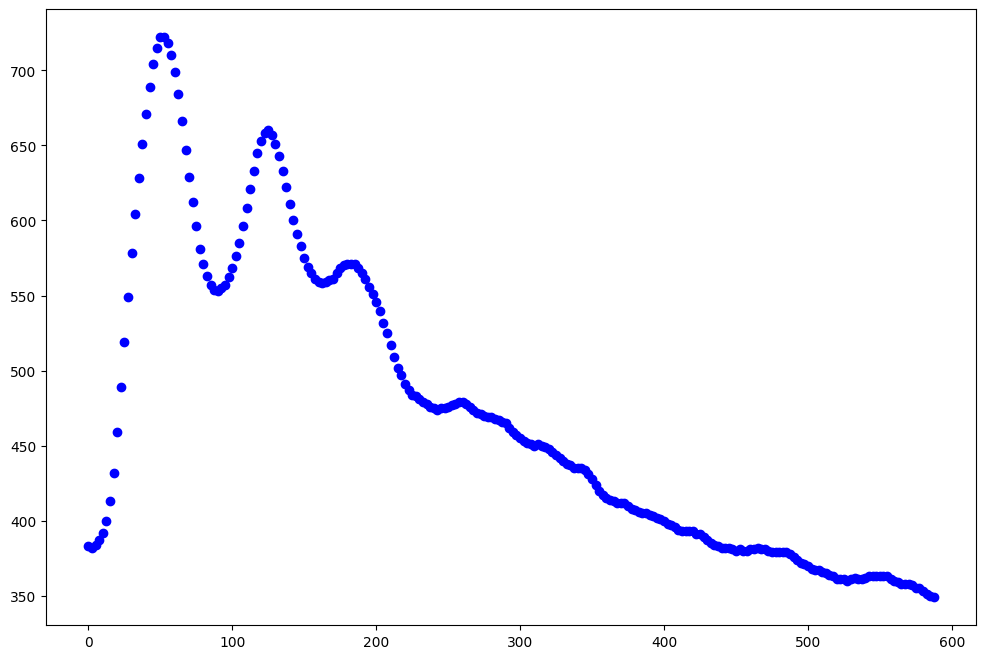

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(df[:]["Tiempo"], df[:]["Diametro"], color="b")

Realizo Substractive Clustering

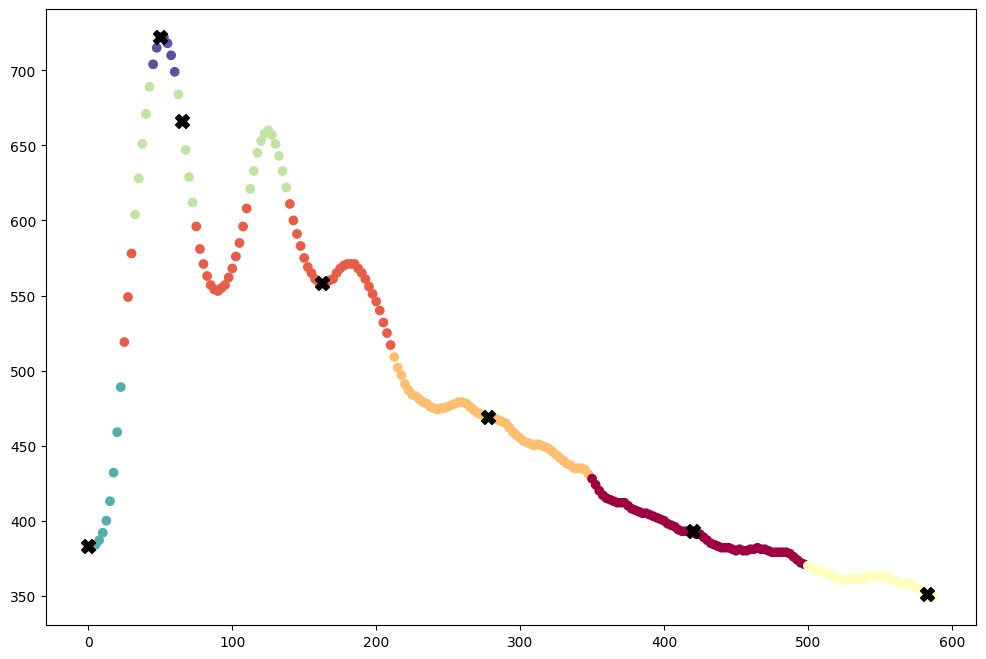

In [ ]:
radio_inferencia = 0.5  #hiperparámetro
r, c = subclust2(df, radio_inferencia) #obtengo radios y centros

plt.figure(figsize=(12, 8))
plt.scatter(df[:]["Tiempo"], df[:]["Diametro"], c = r, cmap = "Spectral")
plt.scatter(c[:,0], c[:,1], c = "black", marker = "X", s = 100);

**Mean Square Error**

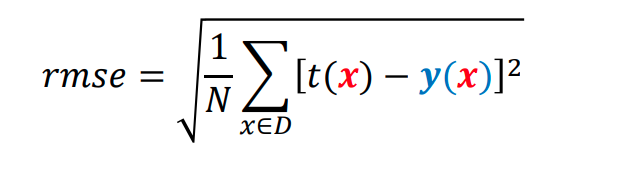

In [ ]:
def mean_square_error (actual, pred):
  actual, pred = np.array(actual), np.array(pred)
  return np.square(np.subtract(actual, pred)).mean()

Aplicación del **FIS Sugeno**

Soluciones FIS: 

--- 0.1204679012298584 seconds ---
[-2.71073446e+11 -9.73172440e+07  6.62788985e+09 -7.53332254e+05
 -1.98345944e+11 -7.70489809e+07  1.79638066e+11  1.56942299e+08
  5.02661924e+11  2.24539937e+07 -2.06731978e+11  1.24021634e+08
 -2.96567766e+11  3.64815556e+06 -3.66557099e+11 -5.60562049e+07
  1.99368569e+11 -1.04719018e+08 -1.26502172e+11  8.83246163e+07
 -6.05463228e+10 -6.57386162e+07  1.42931003e+09  3.66560855e+06
  1.52814397e+11  3.29776246e+07  3.48298874e+10 -2.23659967e+08
 -9.15043382e+10  2.39840013e+07  9.87635064e+10  1.37971422e+07
  1.25886559e+10 -4.53904233e+06 -1.30053840e+11  1.07476104e+08
  5.11789895e+10  4.41478225e+07  1.99504283e+11 -2.16855402e+07
 -2.17754285e+11 -9.35246576e+07 -1.61289235e+11 -9.76478445e+07
 -3.75598501e+11 -4.19968511e+07  8.23495695e+09 -4.88835449e+07
  1.62060546e+11  5.30121785e+07  1.31277493e+10 -2.34747218e+08
 -2.13564030e+11 -1.64887236e+08  1.86344583e+11  2.95403883e+08
  2.46908644e+11 -7.82793049e+07 -3.2

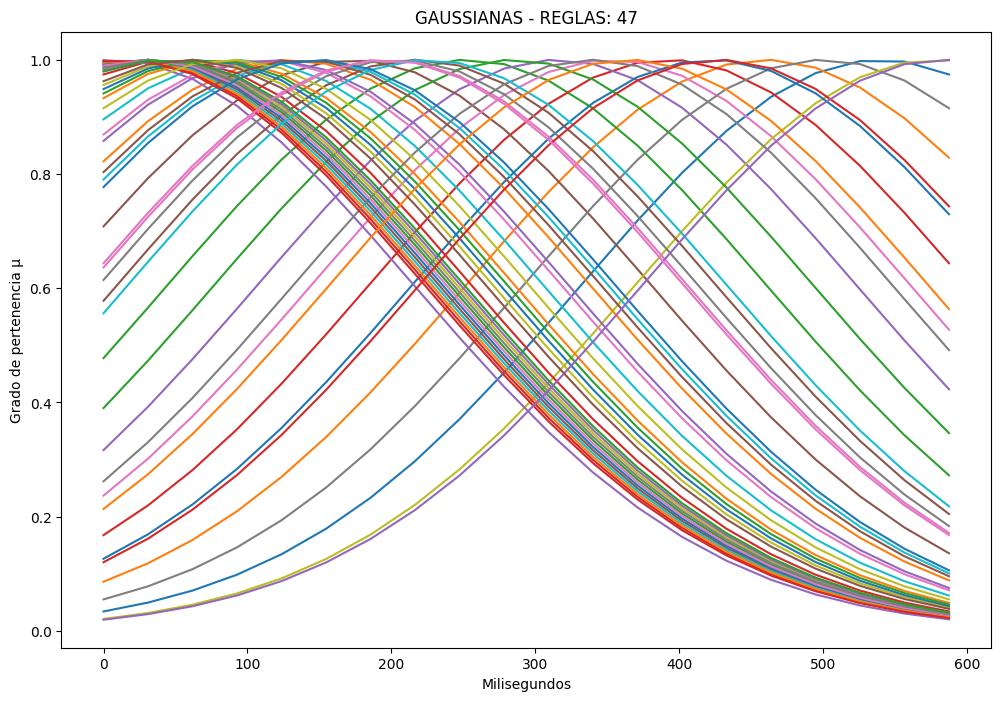

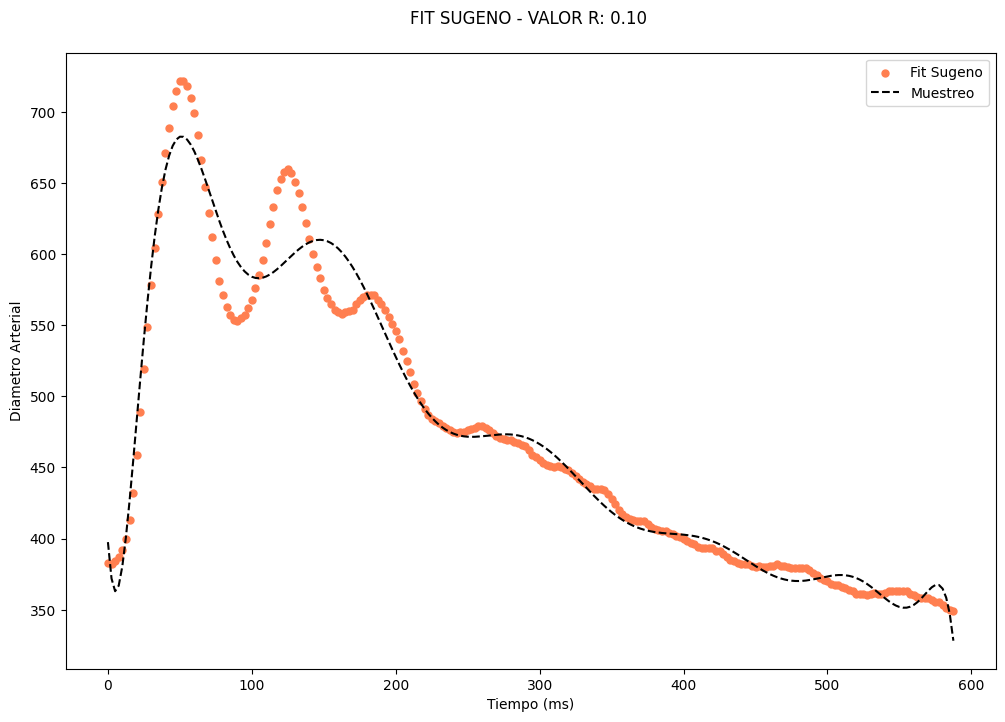

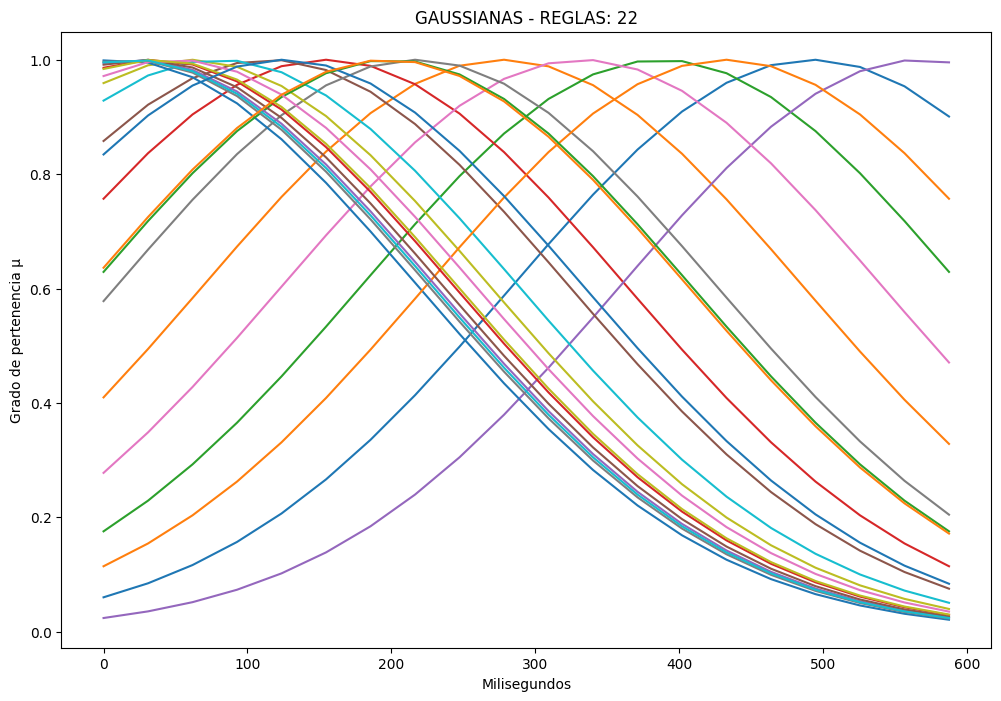

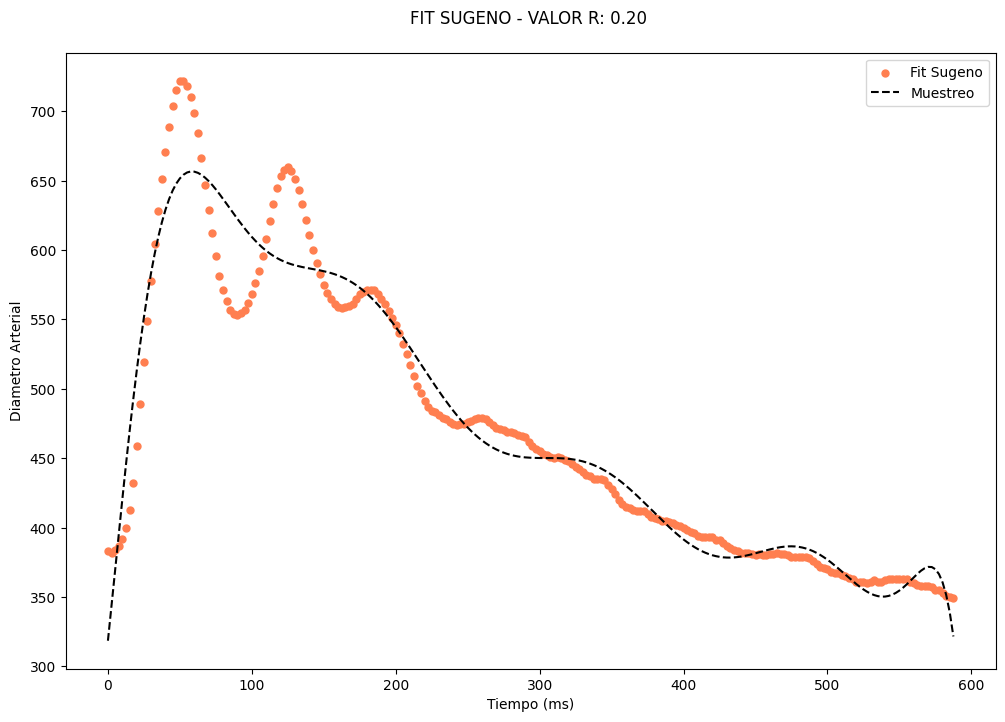

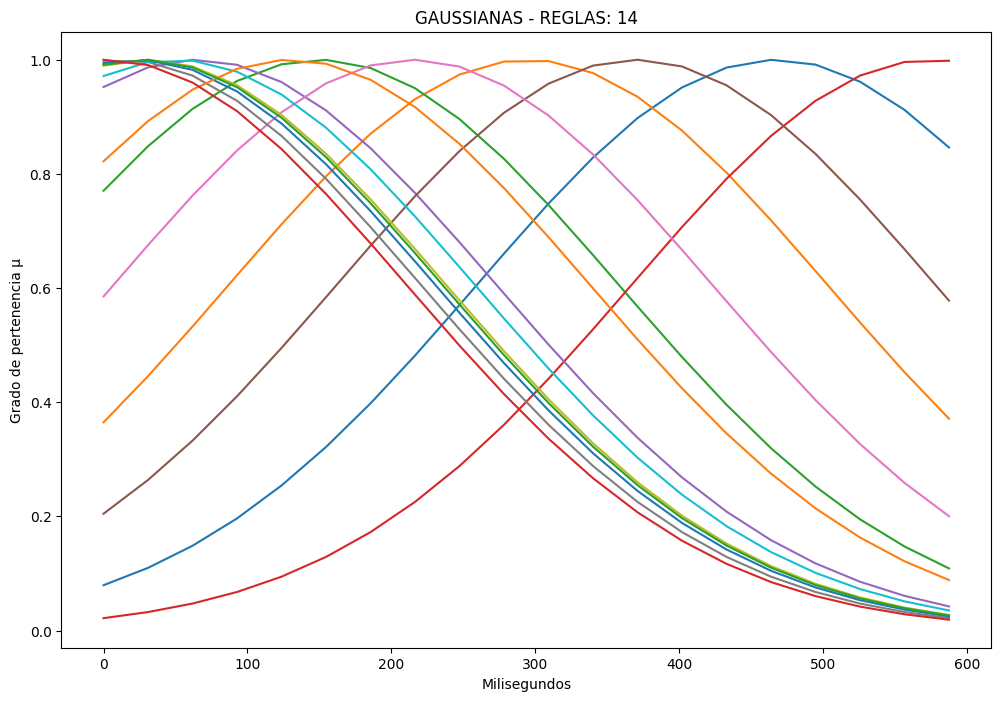

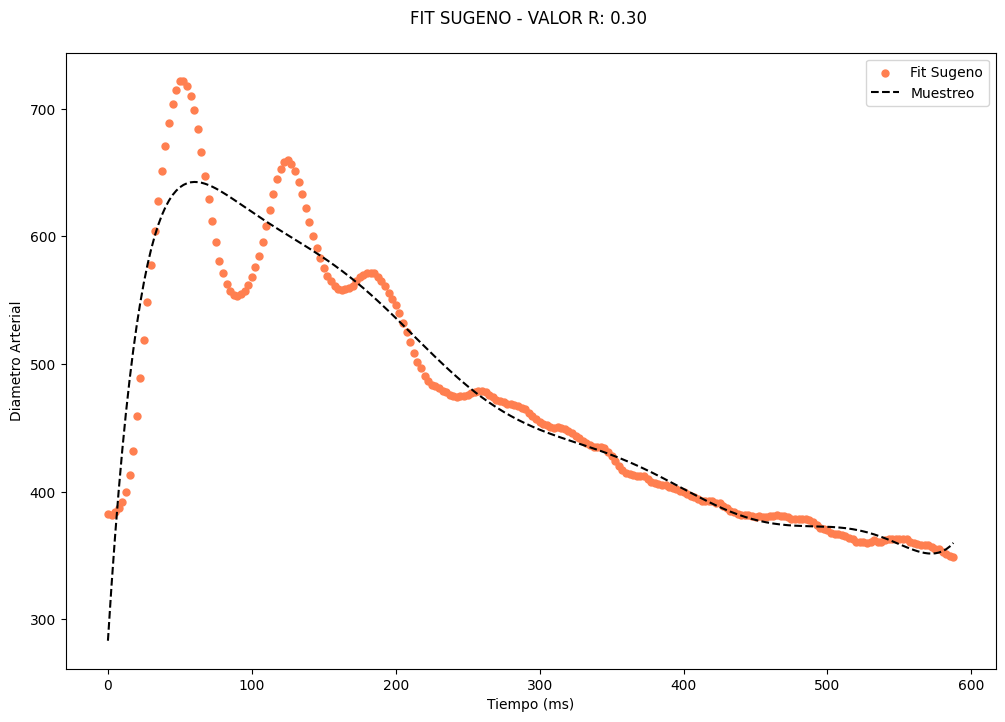

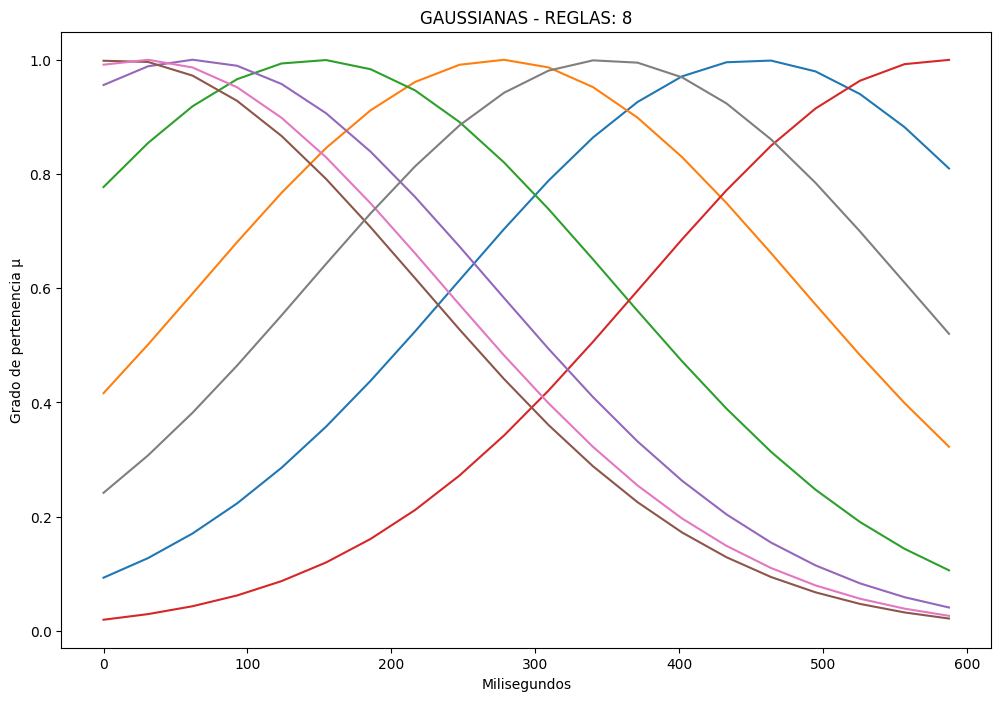

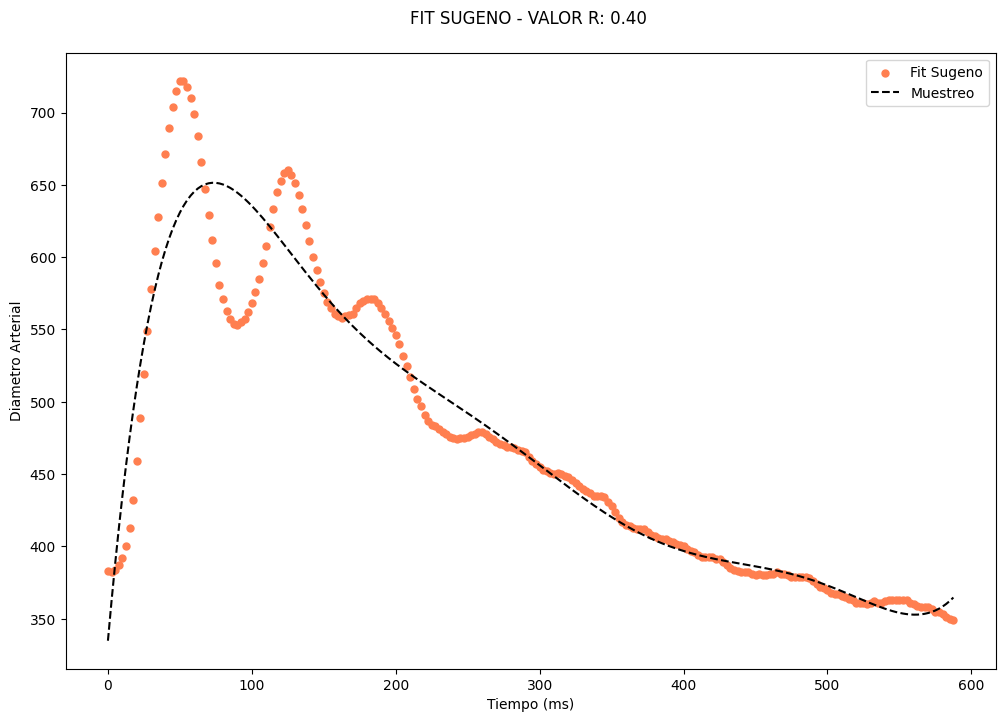

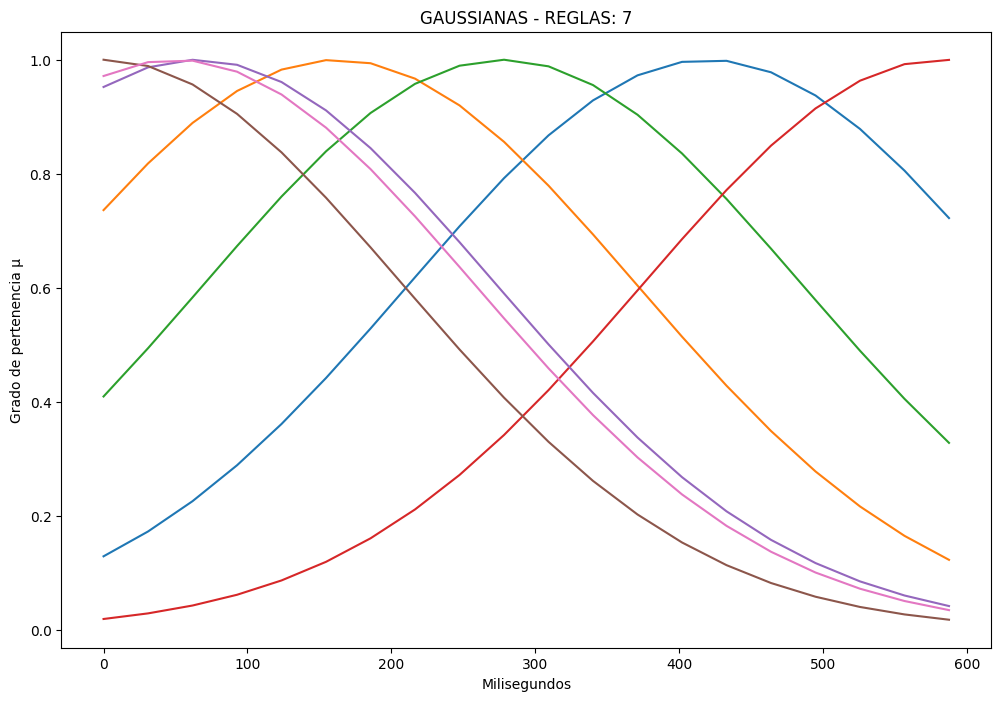

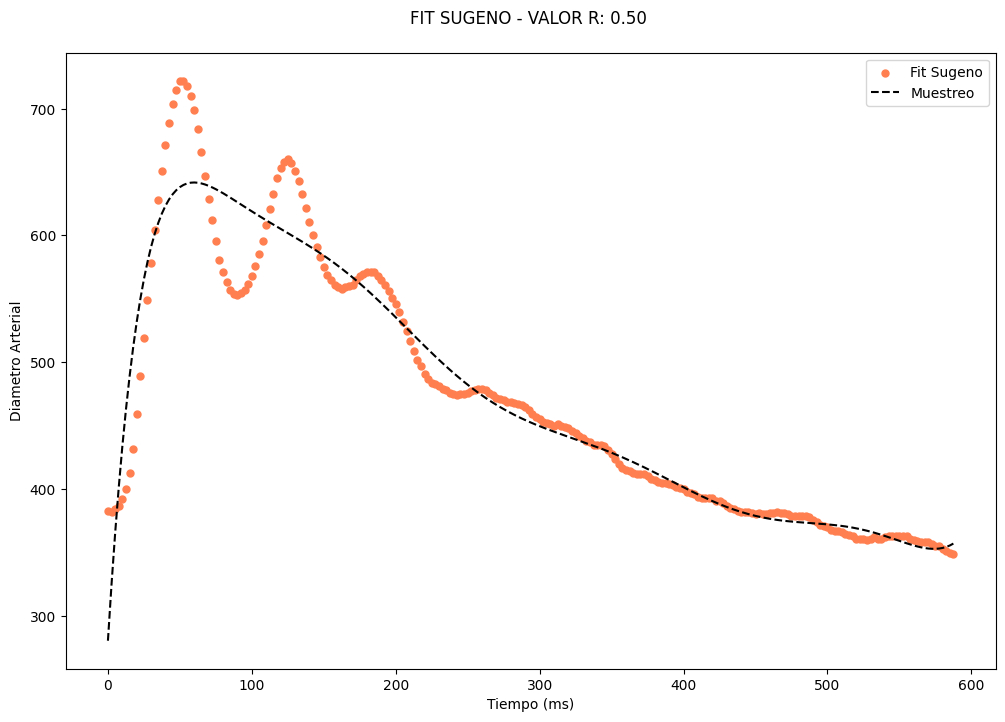

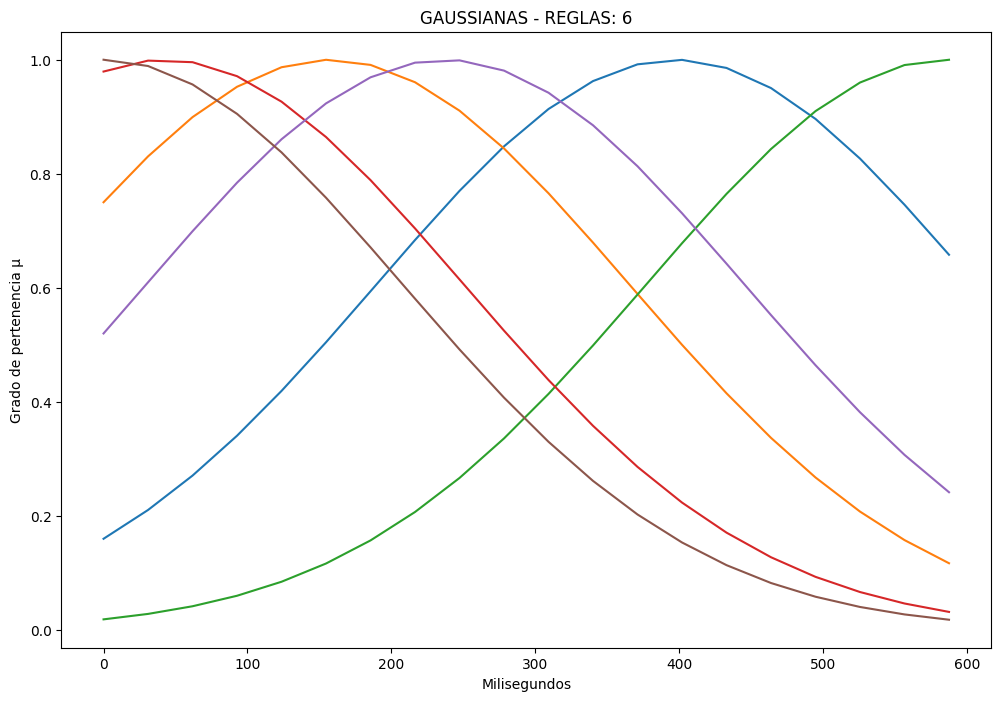

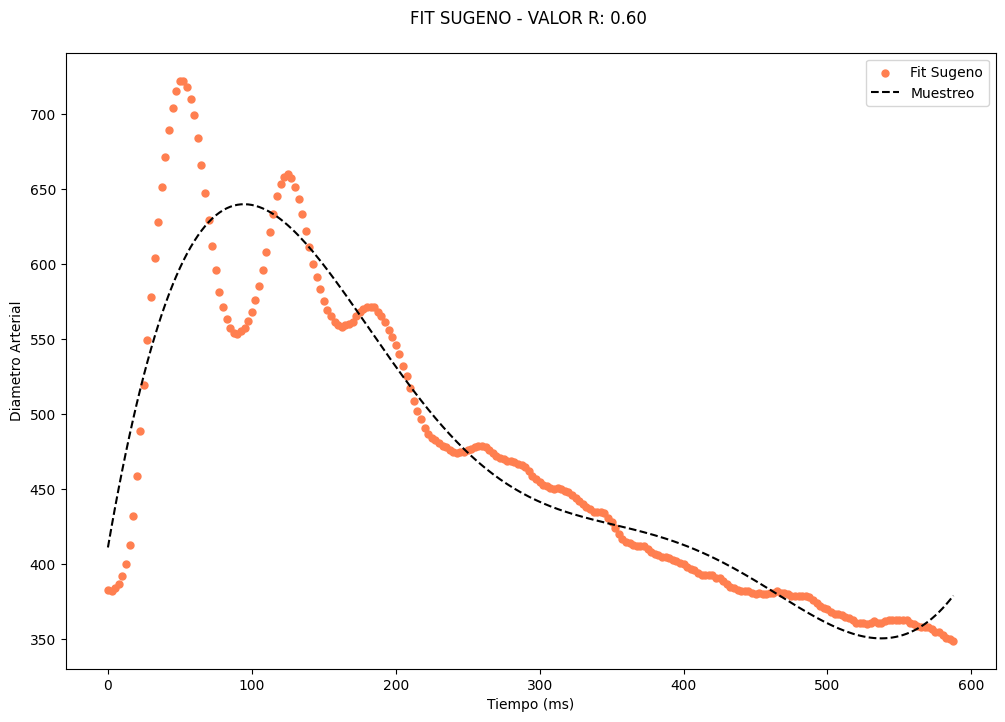

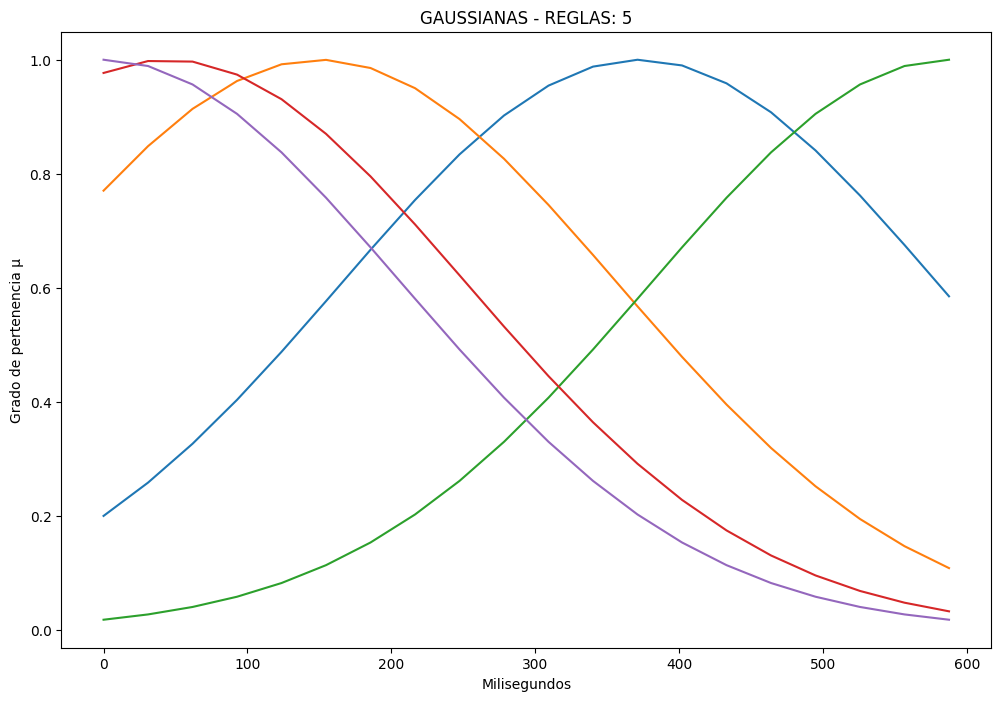

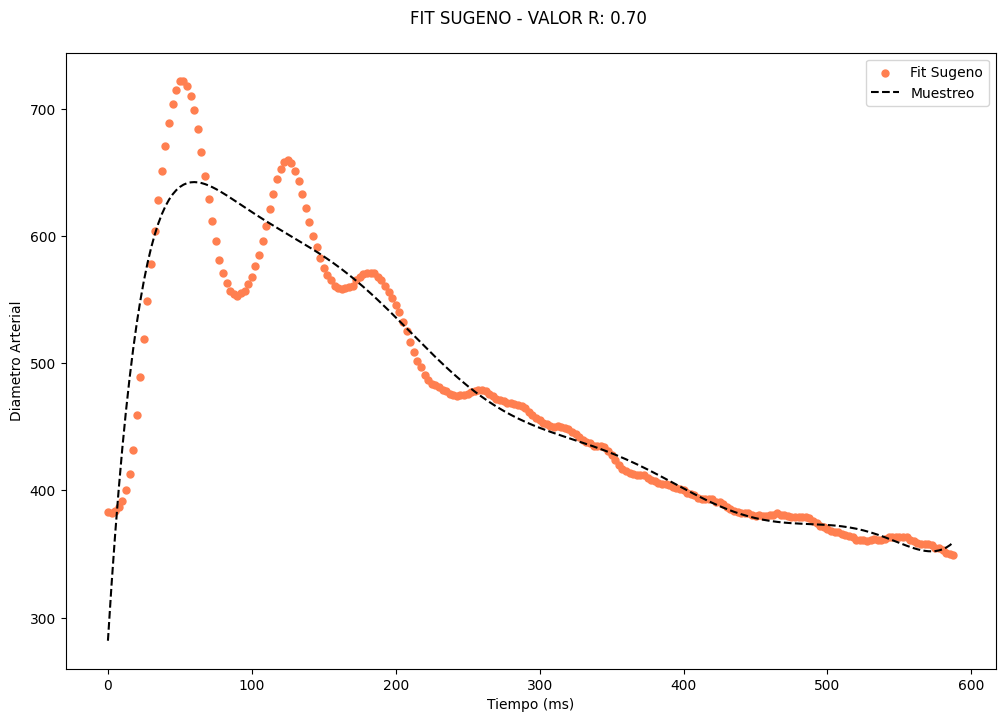

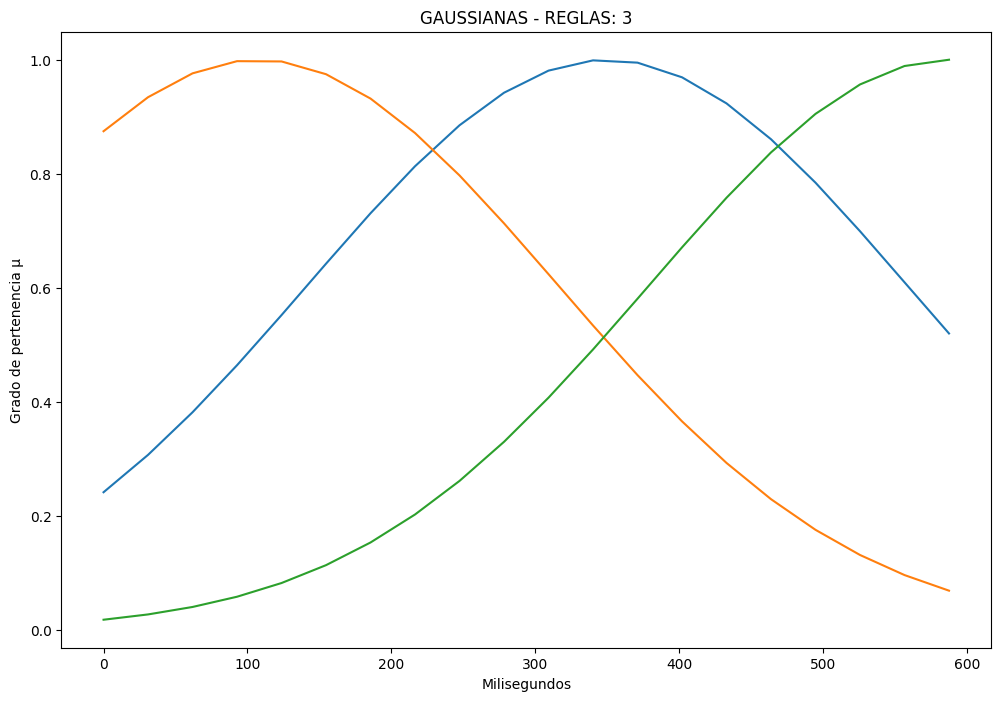

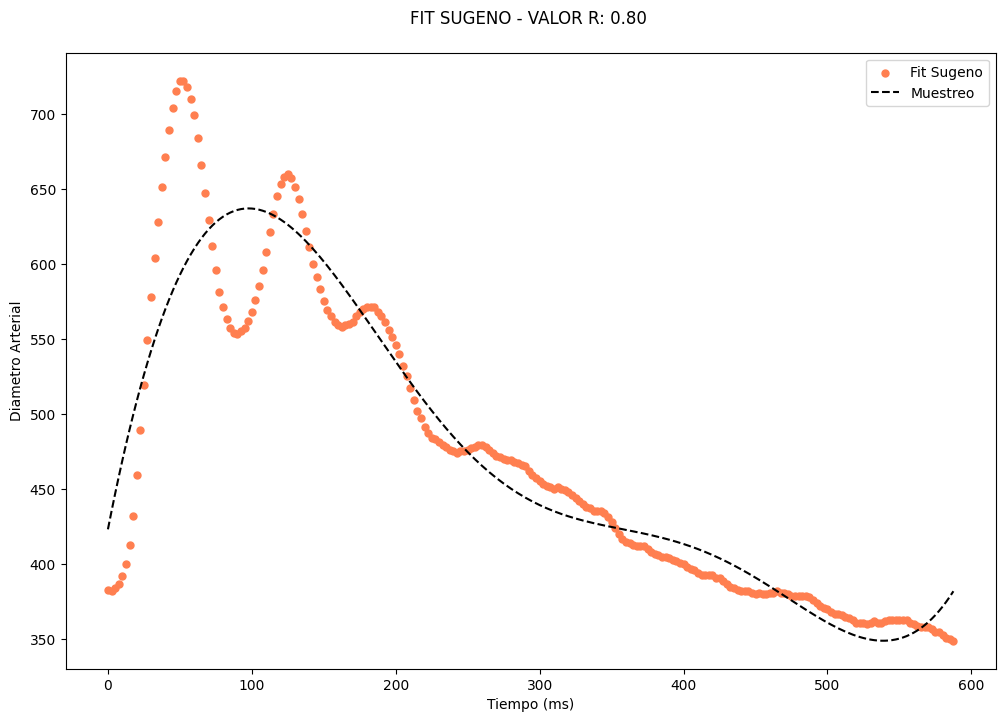

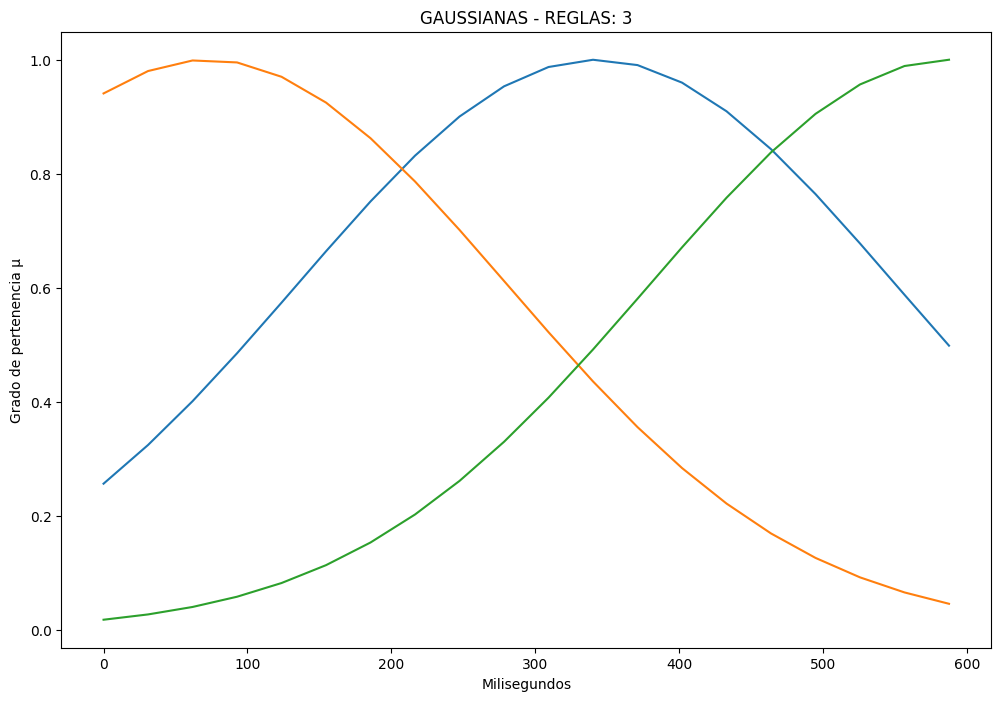

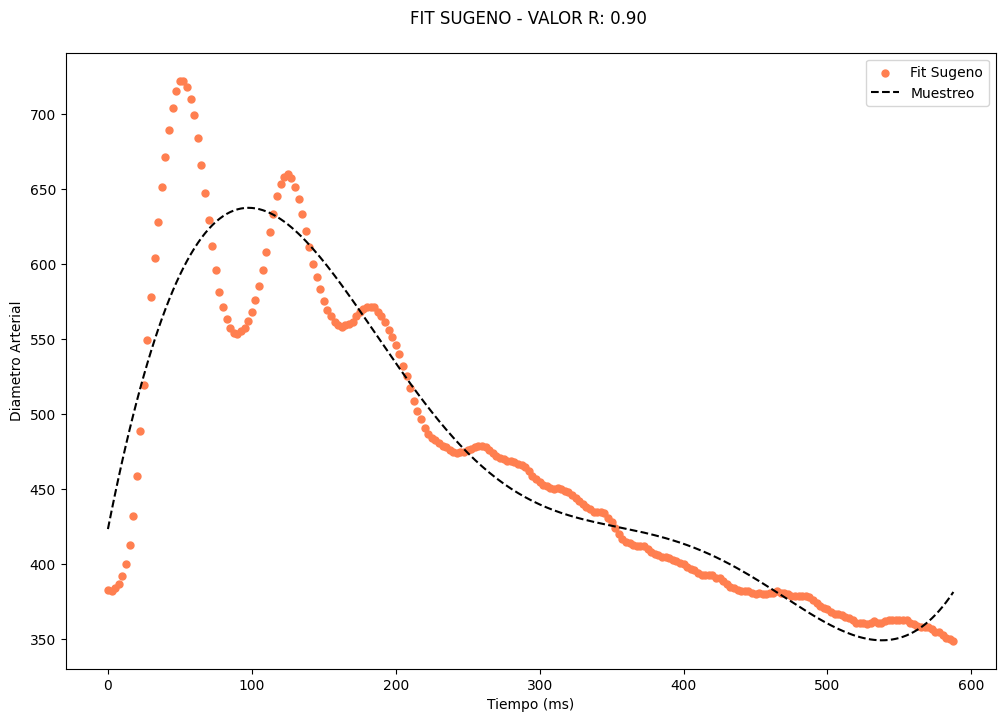

In [ ]:
np_df = np.array(df)
print("Soluciones FIS: \n")

mse_arr = np.zeros((0, 2))

for radii in np.arange(0.1, 1.0, 0.1):
  fis2 = fis()
  fis2.genfis(np_df, radii)
  fis2.viewInputs()

  r = fis2.evalfis(np.vstack(np_df[:, 0]))

  row = np.array([radii, mean_square_error(r, df[:]["Diametro"])])
  mse_arr = np.vstack([mse_arr,row])

  plt.figure(figsize=(12,8))
  plt.title("FIT SUGENO - VALOR R: {:.2f} \n".format(radii))
  plt.xlabel("Tiempo (ms)")
  plt.ylabel("Diametro Arterial")
  plt.scatter(df[:]["Tiempo"], df[:]["Diametro"], c = "coral", s = 25)
  plt.plot(df[:]["Tiempo"], r, c = "black", linestyle = '--');
  plt.legend(["Fit Sugeno", "Muestreo"])


In [ ]:
mse_arr

array([[1.00000000e-01, 3.51988125e+02],
       [2.00000000e-01, 6.46040086e+02],
       [3.00000000e-01, 7.46569545e+02],
       [4.00000000e-01, 8.54379292e+02],
       [5.00000000e-01, 7.43978044e+02],
       [6.00000000e-01, 1.14044011e+03],
       [7.00000000e-01, 7.42804918e+02],
       [8.00000000e-01, 1.20858759e+03],
       [9.00000000e-01, 1.20860058e+03]])

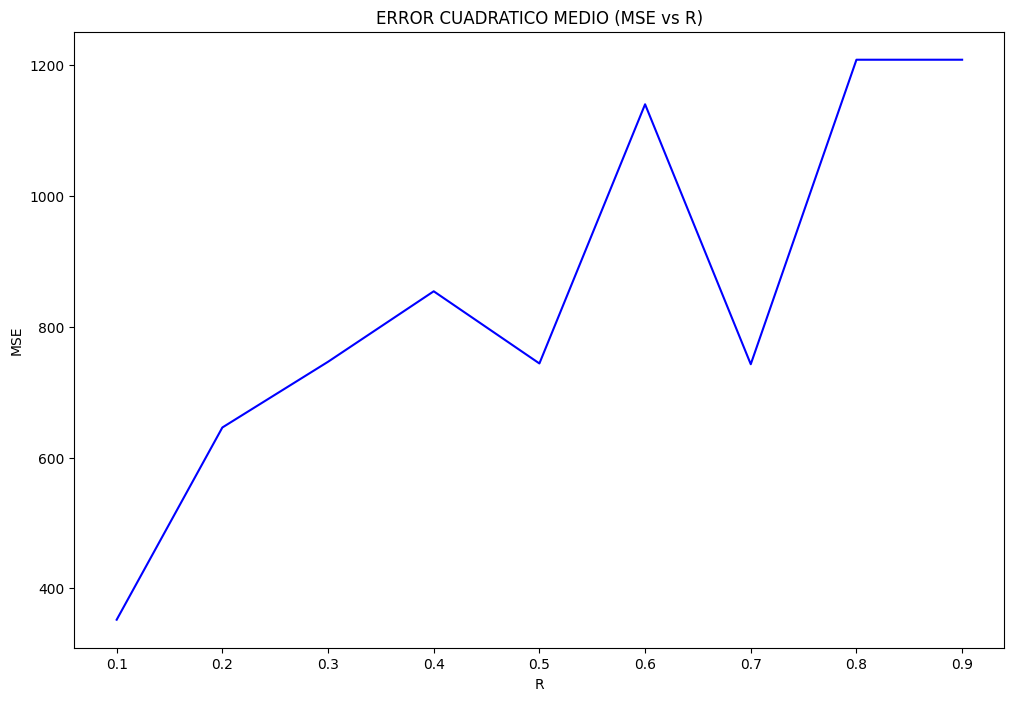

In [ ]:
plt.figure(figsize=(12, 8))
plt.title("ERROR CUADRATICO MEDIO (MSE vs R)")
plt.xlabel("R")
plt.ylabel("MSE")
plt.plot(mse_arr[:,0],mse_arr[:,1], c="blue");